# Overview

The test problem explored in this notebook is adapted from an experiment in 
Tripp et al., Sample-Efficient Optimization in the Latent Space of Deep 
Generative Models via Weighted Retraining (https://arxiv.org/abs/2006.09191). 

We work with a set of 16x16 images. In each image, we place a randomly generated 
black square. We aim to learn a predictive model that maps an image to the area 
of the black square inside it. 
- We first train this model using images and the numerical values for the areas
- We further bring this into a preference learning setting where, instead of 
    numerical values of the black areas, we provide pairwise comparisons of 
    areas in a pair of images. 

It can be seen that the image data are highly structured. We perform PCA on the 
set of images and keep the first 16 principal axes. Then, for each of the two 
types of models above, we try applying PCA to the images and fit a GP from 16
dimensions to 1 dimension, and compare the performance with not doing so (i.e., 
fitting a GP from 256 dimensions to 1 dimension.)

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor
from tqdm.auto import trange


from test_problems.synthetic_problem import generate_principal_axes, PCATestProblem
from src.transforms import (
    generate_random_projection,
    InputCenter,
    LinearProjectionInputTransform,
    LinearProjectionOutcomeTransform,
    PCAInputTransform,
    PCAOutcomeTransform,
    SubsetOutcomeTransform,
)
from src.pref_learning_helpers import gen_initial_real_data, fit_pref_model, gen_comps
from src.diagnostics import check_util_model_fit
from src.models import make_modified_kernel

# import botorch, gpytorch functions
from botorch import fit_gpytorch_model, fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import _filter_kwargs
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import ChainedOutcomeTransform, Standardize
from botorch.models.transforms.input import (
    ChainedInputTransform,
    FilterFeatures,
    Normalize,
)
from botorch.models.pairwise_gp import (PairwiseGP,
                                        PairwiseLaplaceMarginalLogLikelihood)

from gpytorch.kernels import MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

warnings.filterwarnings("ignore")


/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## 1. Construct the Shapes Dataset to Test the Implementation

In [3]:
"""
Construct the Shapes optimization benchmark dataset from Tripp et al.,
Sample-Efficient Optimization in the Latent Space of Deep Generative Models 
via Weighted Retraining, NeurIPS 2020. 
Adapted from: https://github.com/cambridge-mlg/weighted-retraining
"""

# Hyperparameters from 
# https://arxiv.org/abs/2006.09191

grid_size = 16 # image dimension
min_size = 4
max_size = 8
shuffle_seed = None # Int specifying the shuffle seed
min_col = None # min column to start spanning, shifts rectangles to the left
max_col = None # max column to start spanning
num_replicates = 1 # number of times to replicate each point

# Make all the rectangles
print("Making Dataset")
img_list = []
for rect_height in trange(min_size, max_size + 1):
    for rect_width in [rect_height]:  # Because it is squares only
        for row in range(grid_size - rect_height + 1):

            # Specify which columns to span
            if min_col is None:
                min_col = 0
            if max_col is None:
                max_col = grid_size
            for col in range(min_col, min(grid_size - rect_width + 1, max_col)):
                arr = np.zeros((grid_size, grid_size))
                arr[row : row + rect_height, col : col + rect_width] = np.ones(
                    (rect_height, rect_width)
                )
                # Append the same image multiple times
                for _ in range(num_replicates):
                    img_list.append(arr)

img_array = np.array(img_list)
print(f"Dataset created. Total of {len(img_array)} points")
print(f"Array size {img_array.nbytes / 1e9:.1f} GB")

# Possibly shuffle
if shuffle_seed is not None:
    print("Shuffling!")
    np.random.seed(shuffle_seed)
    np.random.shuffle(img_array)

# Calculate areas
areas_array = np.sum(img_array, axis=(1, 2)).astype(float)

Making Dataset


100%|██████████| 5/5 [00:00<00:00, 539.86it/s]

Dataset created. Total of 615 points
Array size 0.0 GB


Text(0.5, 0.98, 'Example Shapes Images')

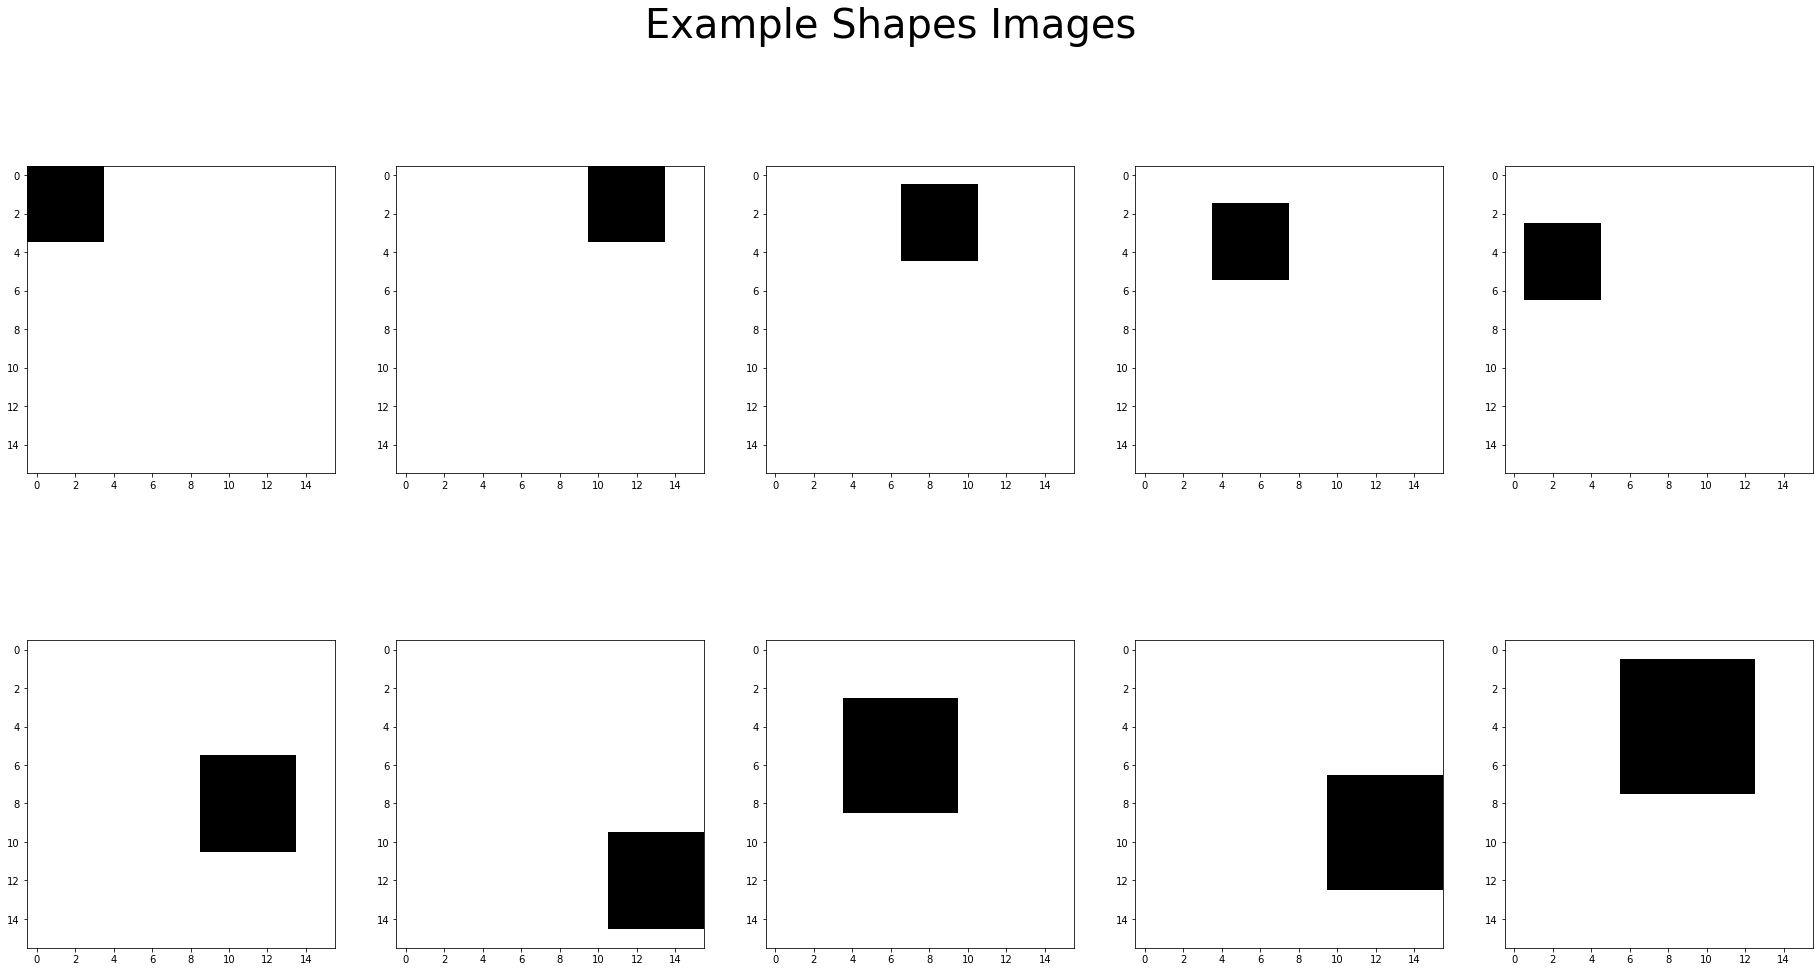

In [4]:
"""
Plot example images from the dataset.
"""

fig, ax = plt.subplots(2, 5, figsize = (32, 16))
ax = ax.reshape(-1)

for i in range(10):
    if i < 5:
        f = ax[i].imshow(img_array[10*i], cmap=plt.cm.gray_r)
    else:
        f = ax[i].imshow(img_array[50*i], cmap=plt.cm.gray_r)

plt.suptitle('Example Shapes Images', fontsize=40)

In [5]:
"""
Define the relative L2-error for the reconstruction of the image data from the low-dimensional PCA embedding.
"""

def rel_l2_error(recons, ground_truth):
    """"Relative L2-error.

    Args: 
        recons: `[b x d]` NumPy array of flattened reconstructions.
        ground_truth: `[b x d]` NumPy array of flattened ground truth images.

    Returns:
        Float specifying the average l2 error across the dataset.
    """

    return np.mean(np.linalg.norm((recons - ground_truth), axis=-1) / np.linalg.norm(ground_truth, axis=-1))

##  2. Test Reconstruction Performance of PCA on the Shapes Dataset

In [6]:
"""
Divide the Shapes dataset into train/test.
"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, areas_array, test_size=0.2, random_state=42)

n_train_data = len(X_train)
n_test_data = len(X_test)
img_dim = len(X_train[0]) # 16 x 16

# Flatten images
X_train = X_train.reshape(n_train_data, img_dim**2)
X_test = X_test.reshape(n_test_data, img_dim**2)

In [7]:
"""
Fit PCA and measure reconstruction error (relative l2 error) on the test set.
"""

import time

from sklearn.decomposition import PCA

start_time = time.time()

# Runtime of PCA is ca. 10 seconds
pca_x = PCA(n_components=16)
pca_x.fit(X_train)
recons_x = pca_x.inverse_transform(pca_x.transform(X_test))
test_error = rel_l2_error(recons_x, X_test)

end_time = time.time()
print(f'Runtime is {(end_time - start_time):.2f} seconds')

def round_binary(reconstructions):
    """round reconstructions to binary pixel values.

    Args:
        reconstructions: NumPy array of reconstructions.

    Returns:
        rounded binary-valued array
    """

    reconstructions = reconstructions > 0.5
    reconstructions = reconstructions.astype(float)
    return reconstructions

recons_x = round_binary(recons_x)


Runtime is 0.12 seconds


In [8]:
print(f'Relative L2 reconstruction error is {100*test_error:.2f}%')


Relative L2 reconstruction error is 48.76%


In [9]:
# 16x256 principal axes
principal_axes = torch.Tensor(pca_x.components_)
print(principal_axes.shape)

torch.Size([16, 256])


## 3. Flatten each image into a vector, then learn a model on the (image, area) data

The image data is a `615x256` tensor, the area data is a `615x1` tensor. 

We implemented PCA as an `InputTranform` object, which can be passed when fitting the model (whether it's `SingleTaskGP` or `PairwiseGP`).

In [10]:
import random

def split_data_helper(dataset_size, split_fraction):
    """
    Helper function for splitting a set of indices randomly into two parts given split_fraction (<0.5). 
    """
    indices = list(range(dataset_size))
    split = int(np.floor(split_fraction * dataset_size))

    test_indices = random.sample(indices, split)
    train_indices = list(set(indices) - set(test_indices))  

    return train_indices, test_indices

### 3.1 Fit a utility model with the numerical utility values (i.e., areas) with and without PCA transform

We call these models `st_abs` and `pca_abs`. 

In [11]:
X = torch.Tensor(img_array).flatten(start_dim=1)
areas = torch.Tensor(areas_array).unsqueeze(1)

print(X.shape, areas.shape)

torch.Size([615, 256]) torch.Size([615, 1])


In [12]:
# split images X and areas into train and test sets

train_indices, test_indices = split_data_helper(dataset_size=615, split_fraction=0.2)
train_X = X[train_indices]
test_X = X[test_indices]
train_areas = areas[train_indices]
test_areas = areas[test_indices]

print(train_X.shape, test_X.shape, train_areas.shape, test_areas.shape)

torch.Size([492, 256]) torch.Size([123, 256]) torch.Size([492, 1]) torch.Size([123, 1])


In [13]:
# Fit single task abs-util model

st_abs = SingleTaskGP(
    train_X,
    train_areas,
    # TODO: need to set covar_module?
)

st_mll = ExactMarginalLogLikelihood(st_abs.likelihood, st_abs)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [14]:
# Fit PCA abs-util model

pca_abs = SingleTaskGP(
    train_X,
    train_areas,
    input_transform=ChainedInputTransform(
                        **{
                            "center": InputCenter(train_X.shape[-1]),
                            "pca": PCAInputTransform(axes=principal_axes),
                        }
                    )
)

pca_mll = ExactMarginalLogLikelihood(pca_abs.likelihood, pca_abs)
fit_gpytorch_model(pca_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (input_transform): ChainedInputTransform(
      (center): InputCenter()
      (pca): PCAInputTransform()
    )
  )
)

In [15]:
# compute area prediction error on the test set

pca_abs_err = ((test_areas - pca_abs.posterior(test_X).mean) / test_areas).mean()

print(f"PCA area prediction relative error {100*pca_abs_err} %")

PCA area prediction relative error -0.09040892869234085 %


In [16]:
st_abs_err = ((test_areas - st_abs.posterior(test_X).mean) / test_areas).mean()

print(f"ST area prediction relative error {100*st_abs_err} %")

ST area prediction relative error -24.758785247802734 %


### 3.2 Fit a utility model with pairwise comparison data with and without PCA transform

More specifically, we take the first 614 entries of train_X, shuffle them, and generate 307 pairwise comparisons. Then we fit a `PairwiseGP` on this data. 

We call these models `st_rel` and `pca_rel`. 

In [44]:
# generate a random permutation of indices [0, ..., 613]
perm_indices = torch.randperm(614)

X_shuffled = X[perm_indices]
areas_shuffled = areas[perm_indices]

In [45]:
import itertools

dataset_size = 307
split_fraction = 0.2

# generate indices of pairs for training and testing
train_pair_indices = list(range(int( dataset_size * (1-split_fraction))))
test_pair_indices = list(set(range(dataset_size)) - set(train_pair_indices))  

# map the pair indices to data indices
# e.g., pair 0 maps to [0,1]
test_indices = list(itertools.chain.from_iterable((2*i, 2*i+1) for i in test_pair_indices))
train_indices = list(itertools.chain.from_iterable((2*i, 2*i+1) for i in train_pair_indices))

train_X = X_shuffled[train_indices]
test_X = X_shuffled[test_indices]

# generate pairwise comparisons for the shuffled area values
# https://github.com/zyyjjj/low_rank_BOPE/blob/main/low_rank_BOPE/src/pref_learning_helpers.py#L55 
area_comps = gen_comps(areas_shuffled)
train_area_comps = area_comps[train_pair_indices]
test_area_comps = area_comps[test_pair_indices]

print(train_X.shape, test_X.shape, train_area_comps.shape, test_area_comps.shape)


torch.Size([490, 256]) torch.Size([124, 256]) torch.Size([245, 2]) torch.Size([62, 2])


In [46]:
# fit single task pairwise model

st_rel = PairwiseGP(
    train_X,
    train_area_comps,
    # TODO: modify covar_module?
)

mll_util = PairwiseLaplaceMarginalLogLikelihood(st_rel.likelihood, st_rel)

fit_gpytorch_mll(mll_util)

PairwiseLaplaceMarginalLogLikelihood(
  (likelihood): PairwiseProbitLikelihood()
  (model): PairwiseGP(
    (likelihood): PairwiseProbitLikelihood()
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(5.000E-03, 2.000E+02)
    )
  )
)

In [47]:
# fit PCA pairwise model 

pca_rel = PairwiseGP(
    train_X,
    train_area_comps,
    input_transform=ChainedInputTransform(
                        **{
                            "center": InputCenter(train_X.shape[-1]),
                            "pca": PCAInputTransform(axes=principal_axes),
                        }
                    ),
    covar_module = make_modified_kernel(ard_num_dims = 16)
)

mll_util = PairwiseLaplaceMarginalLogLikelihood(pca_rel.likelihood, pca_rel)

fit_gpytorch_mll(mll_util)

PairwiseLaplaceMarginalLogLikelihood(
  (likelihood): PairwiseProbitLikelihood()
  (model): PairwiseGP(
    (input_transform): ChainedInputTransform(
      (center): InputCenter()
      (pca): PCAInputTransform()
    )
    (likelihood): PairwiseProbitLikelihood()
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
  )
)

In [58]:
# evaluate model quality not based on prediction of utility value, but on pairwise prediction accuracy

def pref_prediction_accuracy(model, test_X, test_comps):

    posterior_util_mean = model.posterior(test_X).mean
    posterior_util_mean_ = posterior_util_mean.reshape((len(test_comps), 2))
    print('difference in posterior util mean: ', posterior_util_mean_[:,0] - posterior_util_mean_[:,1])

    # in test_comps, [x,y] means x is more preferable than y
    # in posterior util mean, a higher util mean is more preferable
    correct_test_rankings = (posterior_util_mean_[:,0] - posterior_util_mean_[:,1]) * (
        test_comps[:, 0] - test_comps[:, 1]
    )
    pref_prediction_accuracy = sum(correct_test_rankings < 0) / len(
        correct_test_rankings
    )

    return pref_prediction_accuracy

In [59]:
pca_acc = pref_prediction_accuracy(pca_rel, test_X, test_area_comps).item()
print(f"PCA preference prediction accuracy {100*pca_acc} %")

difference in posterior util mean:  tensor([-7.1255e-01,  5.3793e-01,  1.5610e+00,  2.8174e+00,  1.7314e+00,
        -5.8783e+00,  1.7895e-01, -4.0681e+00, -4.5102e+00, -3.6551e+00,
        -5.3811e+00,  3.7249e-02, -3.2811e+00, -1.7677e+00,  7.8398e-01,
         4.8080e+00,  7.9768e-01, -2.9813e+00, -7.8103e+00, -2.0226e+00,
         5.3170e+00,  1.2157e-01, -1.9229e+00,  1.9956e-01,  4.8826e+00,
        -3.1413e+00, -1.0510e+00, -7.6965e+00, -1.1552e+00, -4.4470e-01,
        -4.2598e+00, -2.2128e+00, -1.9964e+00, -1.5681e+00, -4.9878e+00,
         2.5937e+00, -5.0874e+00,  2.3548e+00,  4.6524e+00,  5.9396e+00,
        -2.7446e+00,  3.2465e+00, -3.8883e+00,  1.7568e+00,  7.1271e+00,
         1.2255e-01, -5.5529e+00, -2.7263e-01,  2.9162e+00,  2.9832e+00,
         6.9526e+00,  5.2108e+00, -5.9734e+00,  3.4276e+00,  2.0856e+00,
         8.0911e-01, -4.1844e+00,  4.3699e+00, -5.5120e+00, -6.5455e-03,
         1.1915e+00,  2.2681e+00], grad_fn=<SubBackward0>)
PCA preference prediction acc

In [60]:
st_acc = pref_prediction_accuracy(st_rel, test_X, test_area_comps).item()
print(f"ST preference prediction accuracy {100*st_acc} %")

difference in posterior util mean:  tensor([-1.4227e-20,  2.7318e-23,  3.1080e-13,  6.2743e-16,  3.4705e-15,
        -8.9916e-14,  4.3973e-23, -1.6232e-13, -1.6236e-13, -2.8703e-15,
        -2.4877e-13, -7.4375e-15, -1.5526e-13, -6.5330e-14,  2.0794e-17,
         3.8041e-15,  3.2476e-13, -1.0321e-14, -1.7285e-13, -2.3151e-13,
         7.2877e-15, -2.6215e-23, -3.1942e-15, -7.5955e-14,  7.5857e-15,
        -2.3818e-13,  5.8243e-18, -1.6936e-13, -2.2766e-13,  1.3726e-17,
        -1.6239e-13,  1.4700e-17, -2.5708e-19, -3.0408e-13, -8.2937e-14,
         1.0291e-14, -8.6425e-14,  2.2454e-13,  2.4181e-13,  2.5228e-13,
        -1.9886e-17,  6.9823e-18, -1.6233e-13,  2.3090e-13,  7.9443e-14,
         7.5957e-14, -1.6583e-13, -4.0160e-20,  1.6586e-13,  7.4733e-15,
         2.4178e-13,  3.6439e-15,  7.9446e-14,  5.9172e-19,  1.5160e-13,
         7.6443e-23, -1.5887e-13,  8.2938e-14, -1.6587e-13, -2.2072e-13,
         1.3555e-20,  3.9508e-15], grad_fn=<SubBackward0>)
ST preference prediction accu

In [61]:
# However, I am concerned that the squares dataset is too homogeneous. 
# Here I check how many pairs in the test data are actually the same area value.
# It's hard to evaluate prediction accuracy of our model for these samples
# because the difference is almost never exactly zero.

ties = 0
for i in range(len(test_area_comps)):
    if all(areas_shuffled[2*i] == areas_shuffled[2*i+1]):
        ties += 1
print(f"{ties} pairs out of {len(test_area_comps)} are the same area")

13 pairs out of 62 are the same area


In [ ]:
# TODO: one way around this is perhaps to generate rectangle instead of
# squares, so that we have more variation in area values. 